In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

from rodgersica import rodgers

# Information Content Assessment (ICA) with the Rodgers technique
## Introduction

The intent of this notebook is to demonstrate and perform information content assessments based upon the methodology of Rodgers, 2000. It investigates the relationship between state space (the parameters one wants to determine, such as ocean microplastic concentration) and observation space (what is measured, such as satellite observed earth reflectance). 

The relationship between spaces can be modeled as 

$ \textbf{y} = F(\textbf{x}) $

where $\textbf{y}$ is the vector of measurements, with length $\textit{m}$, corresponding to a state space defined by the parameters $\textbf{x}$, with length $\textit{n}$. $F(\textbf{x})$ is a forward model (simulation) of reality representing the relationship between spaces. In the example noted above, $\textbf{y}$ is what we observe from the satellite, $\textbf{x}$ contains the ocean microplastic parameter we wish to determine (among others), and $ F(\textbf{x})$ is highly nonlinear and cannot be analytically inverted. See the figure below, from Knobelspiesse and Nag, 2018. 

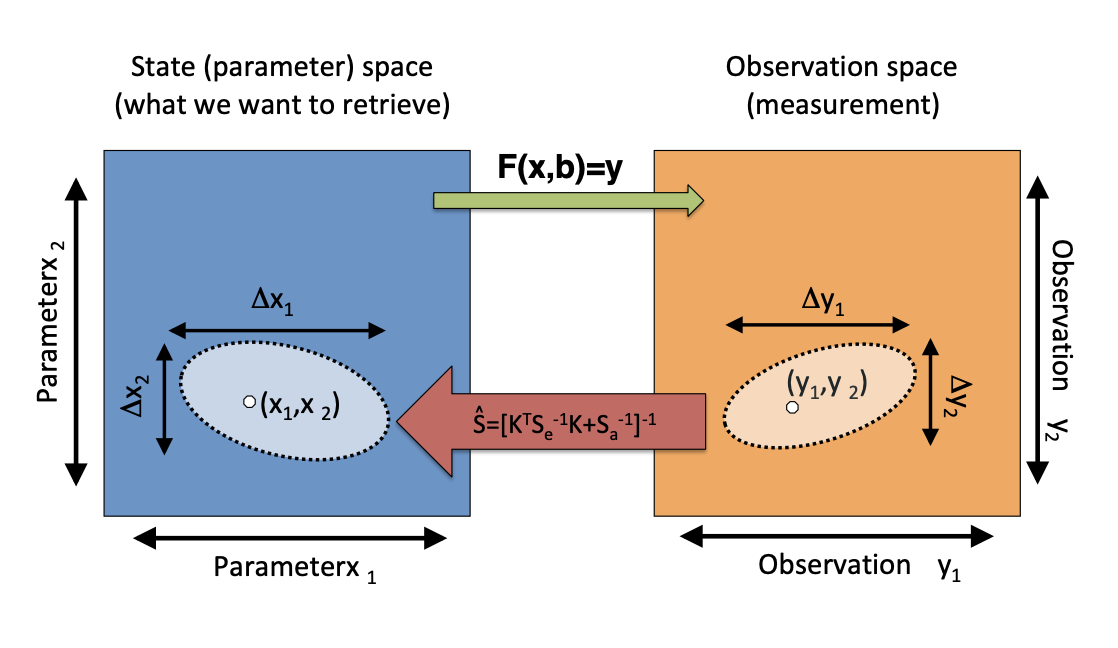

In practice, this technique relies on the Jacobian matrix, comprised of the partial derivatives of $F(\textbf{x})$ with respect to each state space parameter. It describes the sensitivity of the forward model at a defined point within state space:

$ K_{i,j}(\textbf{x}) = \frac{\partial F_i (\textbf{x})}{\partial x_j}$

where $\textit{i}$ has length $\textit{m}$ and $\textit{j}$ has length $\textit{n}$. 



In this work we incorporate estimates of measurement uncertainty, simulation errors, and prior knowledge with this Jacobian to predict the uncertainty in determining parameter values. The approach involves several simplifications and approximations described in Rodgers, 2000 and demonstration publications Knobelspiesse et al., 2012, Chen et al., 2017 and Knobelspiesse and Nag, 2018. For example, this technique assumes that $F(\textbf{x})$ is a close model of physical reality, that differences between it and reality can be quantified, that a retrieval algorithm to determine parameters from observations does not impose additional errors, that $F(\textbf{x})$ is locally linear, and that measurement and parameter uncertainty can be simply expressed with error covariance matricies. In this sense the approach can be considered the 'best case scenario' that demonstrates the capability limits of a measurement system.

Measurement uncertainty is defined by the error covariance matrix, $\textit{S}_{\epsilon}$ with dimension $[m x m ]$. The square of the one sigma uncertainties associated with each $\textit{m}$ is represented on the diagonal, while other elements represent covariance between measurements. 

Another important aspect of ICA is to incorporate what knowledge of parameters exists prior to making a measurement. This is expressed in the $\textit{a priori}$ error covariance matrix, $S_{a}$. This has dimensions $[n x n ]$ and contains the square of the one sigma prior uncertainties on the diagonal (and covariance otherwise). The ICA will not predict retrieval uncertainties worse than this. In some cases, little to no information exists prior to a measurement, in which case an 'uninformative' prior with large assessed uncertainties is used.

The above quantities are combined to predict the retrieval error covariance matrix ($[n x n ]$):

$ \hat{S} =  \left[ K^T S_{\epsilon}^{-1} K + S_{a}^{-1} \right]^{-1} $

Like the other covariance matricies, the square root of the diagonal terms correspond to one sigma uncertainty estimates. 

In some cases, the forward model has known and quantifiable uncertainties. In our example of detecting microplastic with remote sensing observations, this might be how we account for the atmospheric absorption of a trace gas such as ozone. We can estimate ozone and use it in our forward model, but that estimate may have uncertainty with an impact that we can quantify. This can be incorporated into the error covariance matrix in the following manner:

$ S_{\epsilon} = S_{y} +  K_b S_b K_b^T $

where $S_b$ is the error covariance matrix of the parameters defining model parameters and $K_b$ the associated Jacobian. $S_y$ is the instrumental error covariance matrix. The above can be combined to:

$ \hat{S} =  \left[ K^T \left(S_{y} +  K_b S_b K_b^T\right)^{-1} K + S_{a}^{-1} \right]^{-1} $



An alternative formation of the above that has value for ICA is the averaging kernel matrix, $\textbf{A}$, which is the derivative of the posterior state ($\hat{S}$) with respect to the true state:

$ A = \left[ K^T S_{\epsilon}^{-1} K + S_{a}^{-1} \right]^{-1} K^T S_{\epsilon}^{-1} K $

A perfect retrieval has a unity $A$, and individal values of 1 on the diagonal indicates success for that particular parameter. A useful single scalar encapsulation of retrieval success is the Degrees of Freedom for Signal (DFS), which is the trace of the averaging kernel:

$DFS = trace(A)$

We can also calculate the Shannon Information Content: 

$SIC = 0.5 \ln \left| \hat{S}^{-1} S_{a} \right| $

where $ \left| \cdot \right| $ indicates the determinant of the enclosed matrix. This formulation is analogous to the reduction in entropy from the prior to posterior states, and like the $DFS$ represents the information content as a scalar value.

We are also interested in the detectability of a particular parameter or parameters. We formulate this as the probability of a successful non zero retrieval result, given the true value and the ICA predicted retrieval uncertainty. 

$P_{nz} = 1 - 0.5 \left[1+erf \left(\frac{-x_j}{\sqrt{2\hat{S}_{j,j}}}\right) \right]$

where $erf$ is the error function and the subscript $j$ denotes an element within the parameter vector $\textbf{x}$. This is derived from the treatment of the posterior probability as a Gaussian distribution function centered at the value of $x_j$ with width defined by the predicted uncertainty $\sqrt{\hat{S}_{j,j}}$. The integral for all positive values in that distribution compared to the total distribution is the propability of detection. Said another way, the probably is 1 - the cumulative distribution function (integral of the probability distribution function) at the point where it crosses zero. The range of the probability is $0.5 < P_{nz} < 1.0 $, meaning that at worst case we are equally likely to successfully or unsuccessfully make a detection.


## Refrences

Chen, X., Wang, J., Liu, Y., Xu, X., Cai, Z., Yang, D., Yan, C.-X., and Feng, L.: Angular dependence of aerosol information content in CAPI/TanSat observation over land: Effect of polarization and synergy with A-train satellites, Remote Sens. Environ., 196, 163-177, https://doi.org/10.1016/j.rse.2017.05.007, 2017.

Knobelspiesse, K., Cairns, B., Mishchenko, M., Chowdhary, J., Tsigaridis, K., van Diedenhoven, B., Martin, W., Ottaviani, M., and Alexandrov, M.: Analysis of fine-mode aerosol retrieval capabilities by different passive remote sensing instrument designs, Opt. Express, 20(19), 21457-21484, https://doi.org/10.1364/OE.20.021457, 2012.

Knobelspiesse, K. and Nag, S.: Remote sensing of aerosols with small satellites in formation flight, Atmos. Meas. Tech., 11(7), 3935--3954 , https://doi.org/10.5194/amt-11-3935-2018, 2018.

Rodgers, C. D.: Inverse Methods for Atmospheric Sounding: Theory and Practice, World Scientific, Singapore, 2000. 



## Demonstration

We demonstrate this technique by the use of an example forward model:

$ y(\textbf{x},z) = F_s(\textbf{x},z) = x_1 + x_2z + x_2 x_3 z^2 + 0.1 x_1 x_4 z^3 $

where the state space parameters $\textbf{x}$ define the measurement $y$ at various locations in the function, $z$. The latter can be considered an index for different measurement states, such as the wavelength of observation in a multi-spectral remote sensing system. The 's' subscript for the function to the 'simulation' nature of the forward model.

We have chosen this model to be nonlinear, and to have derivatives that vary in state space:

$ \frac{\partial F_s}{\partial x_1}(z) = 1 + 0.1 x_4 z^3 $

$ \frac{\partial F_s}{\partial x_2}(z) = z + x_3 z^2 $

$ \frac{\partial F_s}{\partial x_3}(z) = x_2 z^2 $

$ \frac{\partial F_s}{\partial x_4}(z) = 0.1 x_1 z^3 $

In this case we can expect different values of $ \hat{S} $ throughout parameter space. The solution is to perform the ICA for an ensemble of cases, and consider the result in aggregate. 

Uncertainties in the forward model can also be incorporated into ICA if they can be parameterized and their impacts identified. We can denote those parameter values as $ \textbf{b} = [b_1, b_2, ...] $. In our example let's consider model uncertainty as represented by sinusoids 

$ y(\textbf{x},\textbf{b},z) = F_n(\textbf{x},\textbf{b},z) = F_s(\textbf{x},z) + b_1 \sin(2z+1) + b_2 \sin(3z) $

with partial derivatives

$ \frac{\partial F_n}{\partial b_1}(z) = \sin(2z+1) $

$ \frac{\partial F_n}{\partial b_2}(z) = \sin(3z) $

We've used the subscript 'n' on $F_n$ to denote 'nature'. Now, let's show this for:

8 measurments in the range $[-3,3]$

$\textbf{x}=[1.0,1.0,1.0,1.0]$

$\textbf{b}=[0.1,0.1]$



In [2]:
#make example function and calculate its derivatives
#
# INPUTS - 
# numpts: number of points for independent variable z, to be equally sampled within [-3,3] range
# params: parameter values for model. 4 element vector
# me_params: model error parameters. 2 element vector
# doplot: keyword, set to 1 to make a plot
#
# OUTPUTS - 
# fcn: output function
# jac: jacobian matrix
# fcn_me: output function with model error
# jac_me: jacobian with model errors
#
# NOTE: while the description above uses "z" as the independent value, here it is "x"

def fctns(numpts, params, me_params, doplot=0):
    ln=numpts
    prm=params
    me=me_params

        #create independent values
    xx= np.linspace(-3,3,ln)
    xx_ones=np.empty(ln)
    xx_ones.fill(1.0)
    ln_plot=1001
    xx_plot= np.linspace(-3,3,ln_plot)

        #create function at sampled locations in z
    fcn = prm[0] + prm[1]*xx + prm[1]*prm[2]*xx**2 + 0.1*prm[0]*prm[3]*xx**3
        #same as above but at more locations in z for better plotting
    fcn_plot = prm[0] + prm[1]*xx_plot + prm[1]*prm[2]*xx_plot**2 + 0.1*prm[0]*prm[3]*xx_plot**3

        #derivatives of function
    dfcn_0 = xx_ones + 0.1*prm[3]*xx**3
    dfcn_1 = xx + prm[2]*xx**2
    dfcn_2 = prm[1]*xx**2
    dfcn_3 = 0.1*prm[0]*xx**3

        #function with model error
    fcn_me = fcn + me[0]*np.sin(xx*2+1) + me[1]*np.sin(xx*3)
    fcn_me_plot = fcn_plot + me[0]*np.sin(xx_plot*2+1) + me[0]*np.sin(xx_plot*3)
    
        #function with model error derivatives
    dfcn_me1 = np.sin(xx*2+1)
    dfcn_me2 = np.sin(xx*3)

        #gather data into a jacobian 
    jac=np.array([dfcn_0,dfcn_1,dfcn_2,dfcn_3])

    jac_me=np.array([dfcn_me1,dfcn_me2]) #model error jacobian
    
    #then plot results
    if doplot > 0:
        plt.figure(figsize=(16,16)) 
        plt.subplot(2, 1, 1)

        plt.title("Simulation",fontsize=18)
        plt.plot(xx,fcn,'ks ',label='simulated measurements',color='green')
        plt.plot(xx_plot,fcn_plot,color='green',label=r'simulation $F_s(z) = x_1 + x_2 z + x_2x_3 z^2 + 0.1x_1x_4 z^3 $')
        plt.plot(xx_plot,fcn_me_plot,color='magenta',label=r'nature $F_n(z) = F_s(z) + b_1\sin{2z} + b_2\sin{3z}$' )
        plt.xlabel('z')
        plt.legend(fontsize=18)

        plt.subplot(2, 1, 2)
        plt.title("Jacobians",fontsize=18) 
        plt.plot(xx,dfcn_0,label=r'$\frac{\partial F_s(z) }{\partial x_1}$') 
        plt.plot(xx,dfcn_1,label=r'$\frac{\partial F_s(z) }{\partial x_2}$') 
        plt.plot(xx,dfcn_2,label=r'$\frac{\partial F_s(z) }{\partial x_3}$')
        plt.plot(xx,dfcn_3,label=r'$\frac{\partial F_s(z) }{\partial x_4}$') 
        plt.plot(xx,dfcn_me1,'--',label=r'$\frac{\partial F_n(z) }{\partial b_1}$') 
        plt.plot(xx,dfcn_me2,'--',label=r'$\frac{\partial F_n(z) }{\partial b_2}$') 
        plt.xlabel('z')
        plt.legend(fontsize=18,ncol=3)

        plt.show()

    return fcn, jac, fcn_me, jac_me

/tmp/ipykernel_5210/955546174.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks " (-> color='k'). The keyword argument will take precedence.
  plt.plot(xx,fcn,'ks ',label='simulated measurements',color='green')


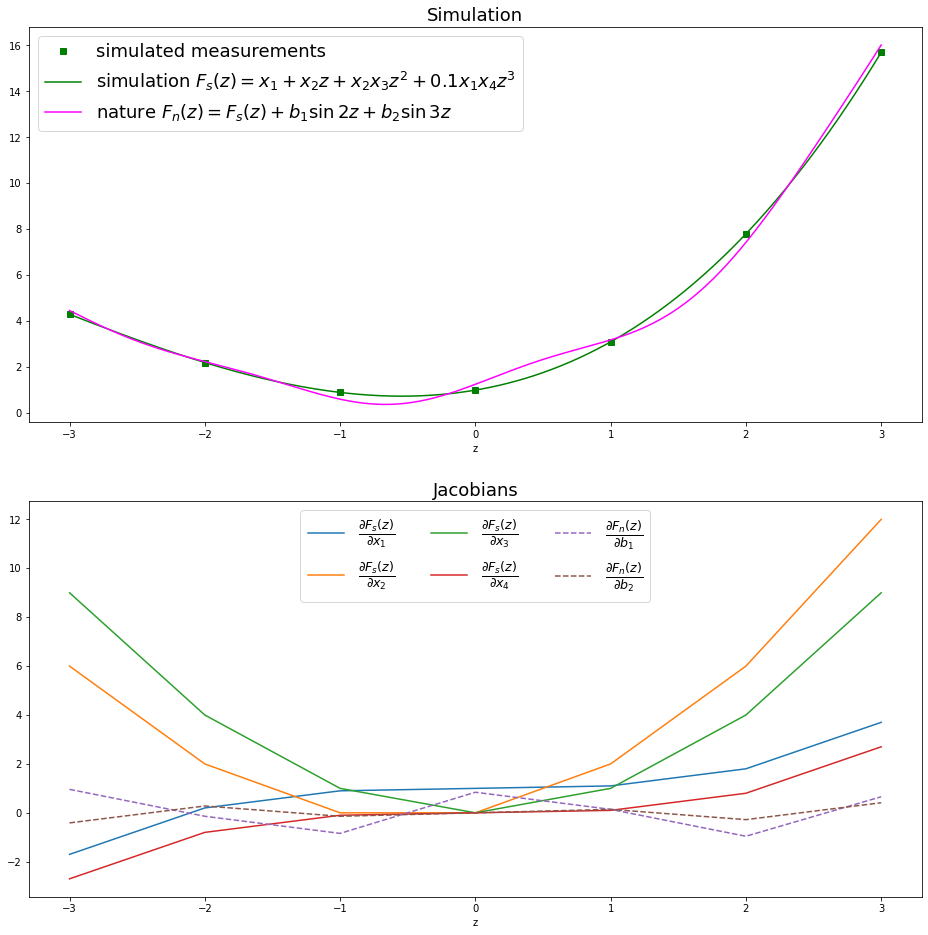

In [3]:
numpts=7 #number of observation points within the [-3,3] range
params=np.array([1.0,1.0,1.0,1.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters

fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params, doplot=1)

The first figure shows the simulated forward model ($F_s$, in green) at the specified sampling locations (boxes). The magenta line shows the true natural state ($F_n$) that we are attempting to model with $F_s$. In a well designed observation system, the difference between $F_s$ and $F_n$ should be small. 

The second figure shows the partial derivatives associated with each parameter for $F_s$ (solid lines) and each model error (dashed lines). Successful observation systems will have dissimilar partial derivatives, indicating that the chosen parameterization is orthogonal. These partial derivatives are assembled into a Jacobian matrix, $\textbf{K}$. Some systems may have the same Jacobians for all locations in state space, but in our model they vary and need to be recalculated for different locations in state space. 

Calculation of the Jacobians are often the most computationally expensive component of an ICA since the forward model is often a complicated radiative transfer model  without analytical derivatives. Thus, the Jacobian is often estimated with a method such as the forward difference approximation, requiring multiple radiative transfer runs. However, ICA experiments and trade studies can be performed with one set of Jacobians because the other components of the analysis often do not require extensive calculation to regenerate for different conditions. These components are the (measurement) error covariance matrix, $S_{\epsilon}$, the model error covariance matrix, $S_b$, and the $\textit{a priori}$ error covaraiance matrix, $S_a$. 

In this example, we use a 'weakly informative' prior, which means the elements on the diagonal representing uncertainty prior to measurement are very large. The intent is to select values that do not offer a constraint on the assessment of information within a measurement. However, large values in $S_a$ does have an impact on the averaging kernel ($\textbf{A}$) and subsequently the $DFS$.

We model the measurement error covariance matrix, $S_{\epsilon}$ as a diagonal matrix with identical values for all elements. That means the measurement system is making observations with equal uncertainty and no correlation. Adding that to $S_{\epsilon}$ is straightforward if desired. 

Finally, the model error covariance matrix describes the uncertainty of model terms in the difference between $F_n$ and $F_s$. The uncertainty represented in $S_b$ expresses that for model parameters that may have errors. For visualization, the case above ($F_n$) is for a given error in $b$. 


In [4]:
    #define diagonal terms for error covariance matricies
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.1**2,0.1**2]) #error on the model error parameters

In [5]:
def print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params ):

    S_hat_diag=np.diagonal(S_hat)
    Err=np.sqrt(S_hat_diag)

    np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    print('Error covariance matrix:')
    print(S_hat)
    print()

    np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
    print('Averaging kernel matrix:')
    print(AvgK)
    print()
    np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
    print('Model Parameters:       ', params)
    print('Number of observations: ', numpts)
    print('A priori uncertainty:   ', np.sqrt(ap))
    print('Uncertainties:          ', Err)
    print('Shannon Information Content:      ', SIC)
    print('Degrees of freedom for signal:    ', DFS)

In [6]:
numpts=7 #number of observation points within the [-3,3] range
params=np.array([1.0,1.0,1.0,1.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.1**2,0.1**2]) #error on the model error parameters
fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params, doplot=0)
S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params )

Error covariance matrix:
[[ 0.08 -0.00 -0.01 -0.08]
 [-0.00  0.07 -0.07 -0.08]
 [-0.01 -0.07  0.07  0.09]
 [-0.08 -0.08  0.09  0.20]]

Averaging kernel matrix:
[[ 0.99916  0.00000  0.00012  0.00083]
 [ 0.00000  0.99934  0.00066  0.00081]
 [ 0.00012  0.00066  0.99931 -0.00093]
 [ 0.00083  0.00081 -0.00093  0.99801]]

Model Parameters:        [ 1.00000  1.00000  1.00000  1.00000]
Number of observations:  7
A priori uncertainty:    [ 10.00000  10.00000  10.00000  10.00000]
Uncertainties:           [ 0.28925  0.25640  0.26210  0.44661]
Shannon Information Content:       17.20558533656743
Degrees of freedom for signal:     3.995824351454505


We can see that the predicted measurment uncertainties are relatively small (less than value of the parameters themselves, and far less than the a priori uncertainty). That is also expressed in the high SIC and DFS and nearly diagonal Averaging kernel matrix. The DFS is nearly 4, the number of free parameters, indicating that this is a well-posed problem. This makes sense because the number of measurements is 7.

The portions of this model are easily changed, and allow for trade and sensitivity studies. As an example, below we repeach the model with a fewer number of measurement points



In [7]:
numpts=3 #number of observation points within the [-3,3] range
params=np.array([1.0,1.0,1.0,1.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.1**2,0.1**2]) #error on the model error parameters
fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params, doplot=0)
S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params )

Error covariance matrix:
[[ 0.26 -0.10  0.07 -0.15]
 [-0.10  30.95 -30.94 -34.29]
 [ 0.07 -30.94  30.94  34.31]
 [-0.15 -34.29  34.31  38.26]]

Averaging kernel matrix:
[[ 0.99744  0.00097 -0.00069  0.00149]
 [ 0.00097  0.69045  0.30944  0.34291]
 [-0.00069  0.30944  0.69063 -0.34307]
 [ 0.00149  0.34291 -0.34307  0.61738]]

Model Parameters:        [ 1.00000  1.00000  1.00000  1.00000]
Number of observations:  3
A priori uncertainty:    [ 10.00000  10.00000  10.00000  10.00000]
Uncertainties:           [ 0.50602  5.56370  5.56215  6.18560]
Shannon Information Content:       13.413508353916868
Degrees of freedom for signal:     2.9959014422748034


Here we've specified a measurement system with only three observations. This is an underdetermined system since there are four free parameters. Accordingly, the DFS is slightly less than 3, and predicted uncertainties are quite high, although less than the a priori values. 

We can also consider the original case, but at a different location within parameter space.

In [8]:
numpts=7 #number of observation points within the [-3,3] range
params=np.array([2.0,2.0,2.0,2.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.1**2,0.1**2]) #error on the model error parameters
fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params, doplot=0)
S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params )

Error covariance matrix:
[[ 0.08 -0.00 -0.01 -0.08]
 [-0.00  0.07 -0.07 -0.04]
 [-0.01 -0.07  0.07  0.05]
 [-0.08 -0.04  0.05  0.11]]

Averaging kernel matrix:
[[ 0.99916  0.00000  0.00006  0.00084]
 [ 0.00000  0.99934  0.00066  0.00041]
 [ 0.00006  0.00066  0.99933 -0.00047]
 [ 0.00084  0.00041 -0.00047  0.99887]]

Model Parameters:        [ 2.00000  2.00000  2.00000  2.00000]
Number of observations:  7
A priori uncertainty:    [ 10.00000  10.00000  10.00000  10.00000]
Uncertainties:           [ 0.28925  0.25650  0.25791  0.33542]
Shannon Information Content:       18.591432999574515
Degrees of freedom for signal:     3.9967152193861306


In this example, we have changed the parameter values from $\textbf{x}=[1.0,1.0,1.0,1.0]$ to $\textbf{x}=[2.0,2.0,2.0,2.0]$. The impact is minimal for the first three parameters, but results in a reduction in uncertainty for $x_4$. The reason for this change is related to the dependence of the partial derivatives on the values of the parameters themselves. That the partials (and thus Jacobians) are dependent on location within parameters space is a reasonable assumption for nonlinear systems. The solution is to perform the ICA at an ensemble of locations within state space, and find a means to visualize the results. 

Finally, let's show the impact of model uncertainties. Our example has as small amount of modeling uncertainty ($\textbf{b}=[0.1,0.1]$) which we can set to zero to examine the difference. For reference, our previous assessment with model uncertainty produced the following results:

Uncertainties:           [ 0.28925  0.25640  0.26210  0.44661]

Shannon Information Content:       17.20558533656743

Degrees of freedom for signal:     3.9958243514545044

With $\textbf{b}=[0.0,0.0]$, those become:

In [9]:
numpts=7 #number of observation points within the [-3,3] range
params=np.array([1.0,1.0,1.0,1.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.0**2,0.0**2]) #error on the model error parameters
fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params, doplot=0)
S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params )

Error covariance matrix:
[[ 0.08 -0.00 -0.01 -0.08]
 [-0.00  0.07 -0.07 -0.08]
 [-0.01 -0.07  0.07  0.09]
 [-0.08 -0.08  0.09  0.20]]

Averaging kernel matrix:
[[ 0.99917  0.00000  0.00012  0.00083]
 [ 0.00000  0.99935  0.00065  0.00081]
 [ 0.00012  0.00065  0.99932 -0.00093]
 [ 0.00083  0.00081 -0.00093  0.99802]]

Model Parameters:        [ 1.00000  1.00000  1.00000  1.00000]
Number of observations:  7
A priori uncertainty:    [ 10.00000  10.00000  10.00000  10.00000]
Uncertainties:           [ 0.28843  0.25591  0.26161  0.44549]
Shannon Information Content:       17.224529553336396
Degrees of freedom for signal:     3.9958441789672516


As we can see, there is a minimal (but non-zero) change. This indicates that model uncertainty is not a particularly relevant source of uncertainty. If it were, we might put greater care into the design of the model, or consider changing some of the model specific parameters into retrievable parameters. 

## Detection Probability 

This ICA system can be modified to determine the probability of successful detection of an individual parameter. In other words, we want to identify the probability that we detect a state space parameter value greater than zero. This depends both on the predicted parameter uncertainty and the parameter value itself. Conceptually, we are integrating the posterior probability distribution function from zero to infinity. 

In [10]:
#calculates the probability of detection given the parameter value (mu) and uncertainty (sigma)
#assumes PDF is gaussian normally distributed
def detect_prob(mu, sigma, doprint=0): 

    Pd = 1-0.5*(1+erf((-1*mu)/(sigma*np.sqrt(2))))  #detection probability, modified from CDF function

    Pd_pcnt_str=str(np.around(Pd*100,decimals=1))+'% positive probability' #string output version

    if doprint > 0:
        print(Pd_pcnt_str)

    return Pd, Pd_pcnt_str

69.1% positive probability


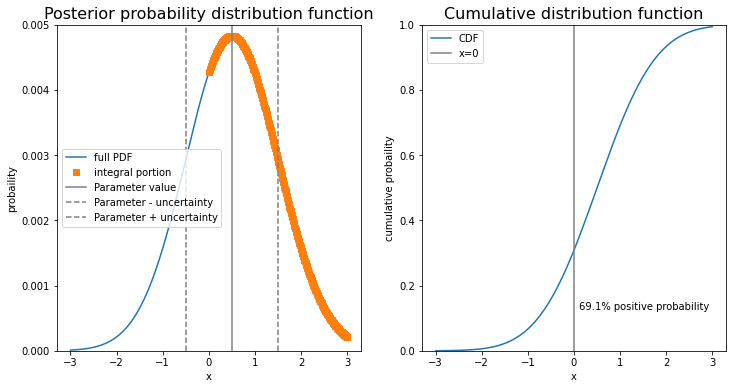

In [11]:
#illustrative example of detection probability calculation

leng=500
xx=(np.linspace(-3,3,leng))

mu=0.5
sig=1.0

exp_part= -0.5*(((xx - mu)/sig)**2) #create PDF
yy = (1./ sig*np.sqrt(2.*np.pi))*np.exp(exp_part)
yy=yy/sum(yy)

cdf = 0.5*(1.0 + erf((xx - mu)/(sig*np.sqrt(2))   )) #cumulative distribution function

Pd, Pd_pcnt_str = detect_prob(mu, sig, doprint=1)

plt.figure(figsize=(12,6)) 
plt.subplot(1, 2, 1) #plot PDF
plt.title("Posterior probability distribution function",fontsize=16)
plt.plot(xx,yy,label='full PDF')
plt.plot(xx[xx > 0],yy[xx > 0],'s ',label='integral portion')
plt.plot([mu,mu],[0,0.005],label='Parameter value',color='grey')
plt.plot([mu-sig,mu-sig],[0,0.005],'--',label='Parameter - uncertainty',color='grey')
plt.plot([mu+sig,mu+sig],[0,0.005],'--',label='Parameter + uncertainty',color='grey')
plt.ylim(0.0,0.005)
plt.xlabel('x')
plt.ylabel('probaility')
plt.legend(fontsize=10)

plt.subplot(1, 2, 2) #plot CDF
plt.title("Cumulative distribution function",fontsize=16)
plt.plot(xx,cdf,label='CDF')
plt.plot([0,0],[0,1],label='x=0',color='grey')
plt.ylim(0.0,1)
plt.xlabel('x')
plt.ylabel('cumulative probaility')
plt.text(0.1, 0.15, Pd_pcnt_str, fontsize=10, verticalalignment='top')

plt.legend(fontsize=10)

plt.show()

The figures above illustrate the concept of probability of detection graphically. The left plot is the posterior probability distribution function (PDF), a gaussian distribution centered at the simulated parameter value, with width defined by the ICA predicted undcertainty. The probability that a retrieval greater than zero represents a true state greater than zero is represented by the fraction of the PDF greater than zero, indicated in orange. 

The cumulative distribution function (CDF) is the integral of the PDF from $-\infty$ to $x$. We want the converse:

$P_d = 1 - CDF(0) = \frac{1}{2} \left[1 - erf \left( \frac{-x_i}{ \sqrt{2\hat{S}_{i,i}}} \right)   \right]   $

where $erf$ is the error function associated with the integral of a gausssian distributed PDF. In the example plotted above, where $x_i = 0.5$ and $\sqrt{\hat{S}_{i,i}} = 1.0$, $P_d = 0.691$. In other words, there is a 69.1% probability that $x_i > 0$. Note that $ 0.5 < P_d < 1.0 $. 

## Ensemble ICA

As illustrated above, if the jacobians depend on location within state space, the ICA results will as well. Detection probability depends on the parameter value even if the jacobian is constant in state space. Additionally, we may wish to investigate how results vary with changes in measurement or model parameter uncertainty. 

In such cases it is important to perform an ensemble of assessments with variable conditions. As a demonstration, we will perform ICA for a range of $x_3$ parameter values and different measurement and uncertainty conditions to show the impact on parameter uncertainty and probability of detection.


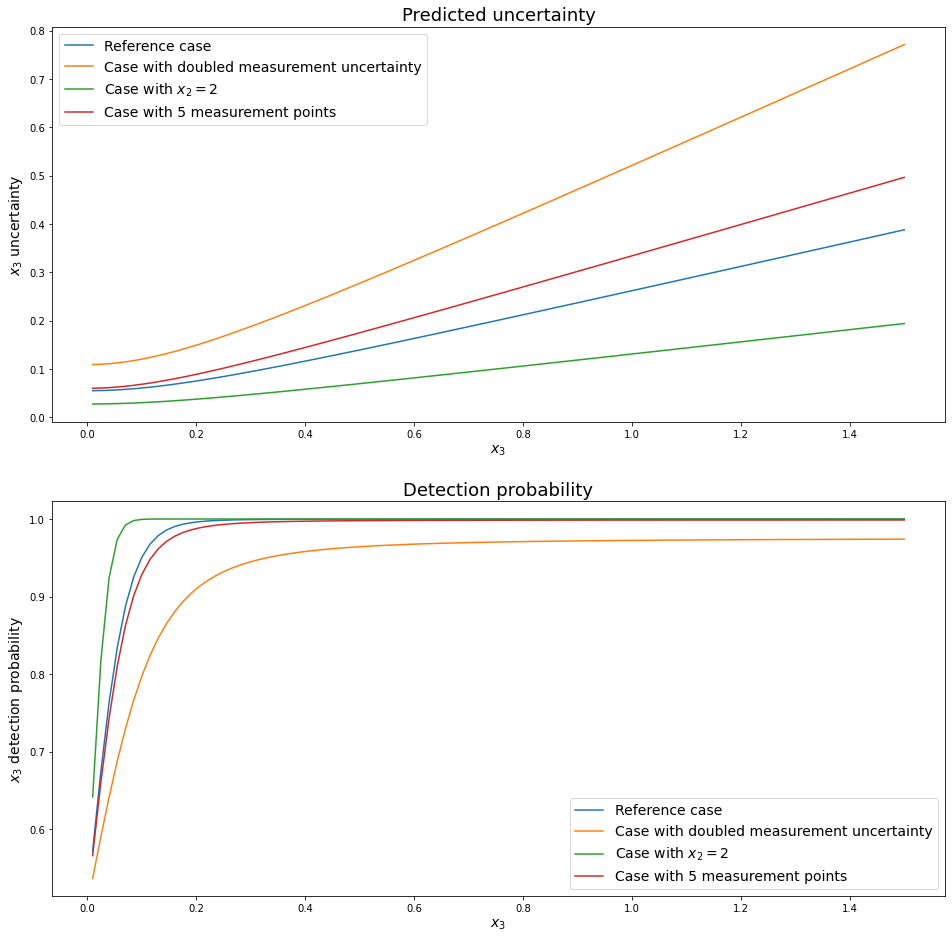

In [12]:
leng=100
p3=(np.linspace(0.01,1.5,leng)) #set x_3 parameter values

err_p3=np.empty(leng) #make variables to store output
det_prob=np.empty(leng)

err_p3_unc=np.empty(leng) #case with doubled measurement uncertainty
det_prob_unc=np.empty(leng)

err_p3_p2=np.empty(leng) #case with different (larger) value of x_2. Here it is = 3, base case = 1
det_prob_p2=np.empty(leng)

err_p3_5pts=np.empty(leng) #case for fewer measurement points (5)
det_prob_5pts=np.empty(leng)

numpts=7 #number of observation points within the [-3,3] range
params=np.array([1.0,1.0,1.0,1.0])  #model parameters
me_params=np.array([0.3,0.3])  #model error parameters
ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
me_err=np.array([0.1**2,0.1**2]) #error on the model error parameters

for x in range(0, leng): #basic case
    params[2]=p3[x]
    
    fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params)    
    S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
    this_unc = np.sqrt(S_hat[2,2])
    Pd, Pd_pcnt_str = detect_prob(p3[x], this_unc, doprint=0)
    err_p3[x] = this_unc
    det_prob[x] = Pd

for x in range(0, leng): #case with doubled measurement uncertainty
    params[2]=p3[x]
    
    err=(np.linspace(1.0,1.0,numpts))**2 
    
    fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params)  
    S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
    this_unc = np.sqrt(S_hat[2,2])
    Pd, Pd_pcnt_str = detect_prob(p3[x], this_unc, doprint=0)
    err_p3_unc[x] = this_unc
    det_prob_unc[x] = Pd
    
for x in range(0, leng): #case with different (larger) value of x_2. Here it is = 3, base case = 1
    params[2]=p3[x]

    err=(np.linspace(0.5,0.5,numpts))**2 
    params[1]=2.0    
    
    fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params)  
    S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
    this_unc = np.sqrt(S_hat[2,2])
    Pd, Pd_pcnt_str = detect_prob(p3[x], this_unc, doprint=0)
    err_p3_p2[x] = this_unc
    det_prob_p2[x] = Pd    
    
for x in range(0, leng): #case for 5 measurement points
    params[2]=p3[x] 
    
    params[1]=1.   
    numpts=5 #number of observation points within the [-3,3] range
    err=(np.linspace(0.5,0.5,numpts))**2 #generate error coveriance matrix diagonals (code also takes 2d input)
    
    fcn, jac, fcn_me, jac_me = fctns(numpts, params, me_params)  
    S_hat, SIC, AvgK, DFS = rodgers(jac, err, ap, model_error=me_err, model_error_jacobian=jac_me)
    this_unc = np.sqrt(S_hat[2,2])
    Pd, Pd_pcnt_str = detect_prob(p3[x], this_unc, doprint=0)
    err_p3_5pts[x] = this_unc
    det_prob_5pts[x] = Pd       
    
#plotting section -----------------------------
plt.figure(figsize=(16,16)) 

plt.subplot(2, 1, 1)
plt.title("Predicted uncertainty",fontsize=18)
plt.plot(p3,err_p3,label='Reference case')
plt.plot(p3,err_p3_unc,label='Case with doubled measurement uncertainty')
plt.plot(p3,err_p3_p2,label='Case with $x_2=2$')
plt.plot(p3,err_p3_5pts,label='Case with 5 measurement points')
plt.xlabel('$x_3$',fontsize=14)
plt.ylabel('$x_3$ uncertainty',fontsize=14)
plt.legend(fontsize=14)

plt.subplot(2, 1, 2)
plt.title("Detection probability",fontsize=18)
plt.plot(p3,det_prob,label='Reference case')
plt.plot(p3,det_prob_unc,label='Case with doubled measurement uncertainty')
plt.plot(p3,det_prob_p2,label='Case with $x_2=2$')
plt.plot(p3,det_prob_5pts,label='Case with 5 measurement points')
plt.xlabel('$x_3$',fontsize=14)
plt.ylabel('$x_3$ detection probability',fontsize=14)
plt.legend(fontsize=14)    
    
plt.show()        

As expected, the various conditions predict different uncertainty and detection probabilities. For this assessment of $x_3$, we can see that the expected measurment uncertainty increases with $x_3$, but not as fast as $x_3$ itself. That means that the relative uncertainty decreases as $x_3$ increases. Detection probability rapidly increases with increasing $x_3$ from 50% (no detection information) to 100% at roughly $x_3 = 0.25$ (for the reference case). Two factors contribute to this rapid increase: the distance of $x_3$ from zero, and the decreasing relative uncertainty as $x_3$ increases. 

Doubling the measurement error uncertainty (orange) results in a greater predicted uncertainty and lower detection probability. The latter never converges to 100%. Likewise, reducing the number of observation points from 7 to 5 also results in higher uncertainty and lower detection probability - but much less so than in the case of doubled measurement uncertainty. This is an example of how ICA can be used for trade studies: we would conclude that it is better to have fewer measurements of similar uncertainty than to preserve the number of measurements but worsen uncertainty. A caveat is indicated by the different result for another location in state space, $x_2 = 2$, where the results may be different.

## Conclusions

We have demonstrated the use of one type of Information Content Assessment (ICA), which is based upon the Bayesian approach described in Rodgers, 2000. This approach assumes uncertainties can be defined in error covariance matricies which represent uncertainties as one sigma in a Gaussian distribution. Model derived Jacobians are the basis of this method, and as in all cases the realism depends on that of the model itself. While there is a provision for model uncertainties ($S_b$), 'unknown unknowns' are not characterized. In this sense the results represent a best case, and real world results can never do better than this. 

Despite these limitations, ICA can be a very powerful tool for sensitivity assessment, trade studies, and identification of the optimum retrieval parameterization scheme. This demo is expressed with an easy to understand nonlinear equation from which Jacobians can be analytically derived. Application to real problems may involve the use of higher dimensional nonlinear models without analytical derivatives. In this case Jacobians can be approximated with a method such as forward difference. 

If you wish to implement this approach on your own results, see the notebook at "RodgersICA.ipynb"

-Kirk Knobelspiesse, V1 on 2022/05/31

